In [43]:
import pandas as pd
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy import interpolate
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [15]:
w_list = sorted(glob("data/water_data/*.csv"))

In [41]:
# 훈련 데이터 수집
# 실험 결과 "tototf", "fw_1019630" 두가지만 사용할때가 가장 좋았음
# iloc로 참조시 650초 소요
# dict로 바꿔서 참조시 11초 소요

train_data = []
train_label = []
train_data_append = train_data.append
train_label_append = train_label.append
for i in w_list[:-1]:
    tmp = pd.read_csv(i)
    tmp = tmp.replace(" ", np.nan)
    tmp = dict(tmp)
    for j in tqdm(range(len(tmp["tototf"])-1)):
        # 라벨이 이상하면 패스 : 0이하이거나, nan이거나, 20000 이상의 이상치거나
        #if (tmp.iloc[j+1]["tototf"] <= 0) or (tmp.iloc[j+1]["tototf"] != tmp.iloc[j+1]["tototf"]) or (tmp.iloc[j+1]["tototf"] > 20000):
        if (tmp["tototf"][j+1] <= 0) or (tmp["tototf"][j+1] != tmp["tototf"][j+1]) or (tmp["tototf"][j+1] > 20000):
            continue
        # 데이터가 이상하면 패스
        #if (tmp.iloc[j]["tototf"] <= 0) or (tmp.iloc[j]["tototf"] != tmp.iloc[j]["tototf"]) or (tmp.iloc[j]["tototf"] > 20000):
        if (tmp["tototf"][j] <= 0) or (tmp["tototf"][j] != tmp["tototf"][j]) or (tmp["tototf"][j] > 20000):
            continue
        if (tmp["fw_1019630"][j] <= 0) or (tmp["fw_1019630"][j] != tmp["fw_1019630"][j]):
            continue

        train_data_append([tmp["tototf"][j], tmp["fw_1019630"][j]])
        train_label_append(tmp["tototf"][j+1])

100%|██████████| 26495/26495 [00:01<00:00, 19950.28it/s]


In [44]:
print(np.array(train_data).shape)
print(np.array(train_label).shape)
train_data = np.array(train_data)
train_label = np.array(train_label)

# 263498

(263498, 2)
(263498,)


In [46]:
# 검증

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2)

model = LinearRegression()
model.fit(X_train, y_train)
print(mean_absolute_error(model.predict(X_test), y_test))
model = XGBRegressor()
model.fit(X_train, y_train)
print(mean_absolute_error(model.predict(X_test), y_test))
model = RandomForestRegressor()
model.fit(X_train, y_train)
print(mean_absolute_error(model.predict(X_test), y_test))

10.130794506059829
11.327235699497637
13.410752935031894


In [47]:
model = LinearRegression()
model.fit(train_data, train_label)

LinearRegression()

In [48]:
model.feature_importances_

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

In [49]:
w_list = sorted(glob("data/water_data/*.csv"))

In [54]:
df = pd.read_csv(w_list[0], index_col=0)
for i in w_list[1:-1]:
    df = pd.concat([df, pd.read_csv(i, index_col=0)])
df_2022 = pd.read_csv(w_list[-1], index_col=0)

column = "tototf"
print(f"nan count of {column} : {df[str(column)].isna().sum()}")
print(f"zero count of {column} : {(df[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(df[str(column)] > 20000).sum()}")
print("-----------")
print(f"nan count of {column} : {df_2022[str(column)].isna().sum()}")
print(f"zero count of {column} : {(df_2022[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(df_2022[str(column)] > 20000).sum()}")
impute_df = dict(df.copy())
impute_2022 = dict(df_2022.copy())

nan count of tototf : 707
zero count of tototf : 446
anomaly count of tototf : 2
-----------
nan count of tototf : 36
zero count of tototf : 6
anomaly count of tototf : 0


In [69]:
# dict 리팩토링 완료

for i in tqdm(range(len(impute_df["tototf"])-1)):
    # 타겟이 0이하이거나 nan이거나 이상치일때
    if (impute_df["tototf"][i+1] <= 0) or (impute_df["tototf"][i+1] != impute_df["tototf"][i+1]) or (impute_df["tototf"][i+1] > 20000):
        # tototf 데이터가 모두 정상일때
        if (impute_df["tototf"][i] > 0) and (impute_df["tototf"][i] == impute_df["tototf"][i]) and (impute_df["tototf"][i] <= 20000):
            # fw_1019630 데이터가 모두 정상일때
            if (impute_df["fw_1019630"][i] > 0) and (impute_df["fw_1019630"][i] == impute_df["fw_1019630"][i]):
                impute_df["tototf"][i+1] = model.predict(np.array([impute_df["tototf"][i], impute_df["fw_1019630"][i]]).reshape(1,-1))

for i in tqdm(range(len(df_2022["tototf"])-1)):
    if (df_2022["tototf"][i+1] <= 0) or (df_2022["tototf"][i+1] != df_2022["tototf"][i+1]) or (df_2022["tototf"][i+1] > 20000):
        # tototf 데이터가 모두 정상일때
        if (df_2022["tototf"][i] > 0) and (df_2022["tototf"][i] == df_2022["tototf"][i]) and (df_2022["tototf"][i] <= 20000):
            # fw_1019630 데이터가 모두 정상일때
            if (df_2022["fw_1019630"][i] > 0) and (df_2022["fw_1019630"][i] == df_2022["fw_1019630"][i]):
                df_2022["tototf"][i+1] = model.predict(np.array([df_2022["tototf"][i], df_2022["fw_1019630"][i]]).reshape(1,-1))



100%|██████████| 264959/264959 [00:02<00:00, 91946.82it/s]

100%|██████████| 11375/11375 [00:00<00:00, 50775.04it/s]


In [70]:
impute_df = pd.DataFrame.from_dict(impute_df)
df_2022 = pd.DataFrame.from_dict(df_2022)

column = "tototf"
print(f"nan count of {column} : {impute_df[str(column)].isna().sum()}")
print(f"zero count of {column} : {(impute_df[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(impute_df[str(column)] > 20000).sum()}")
print("-----------")
print(f"nan count of {column} : {df_2022[str(column)].isna().sum()}")
print(f"zero count of {column} : {(df_2022[str(column)]<=0).sum()}")
print(f"anomaly count of {column} : {(df_2022[str(column)] > 20000).sum()}")

nan count of tototf : 0
zero count of tototf : 0
anomaly count of tototf : 0
-----------
nan count of tototf : 0
zero count of tototf : 0
anomaly count of tototf : 0


In [71]:
impute_df.to_csv("data_2012~2021 impute_tototf.csv")
df_2022.to_csv("data_2022 impute_tototf.csv")

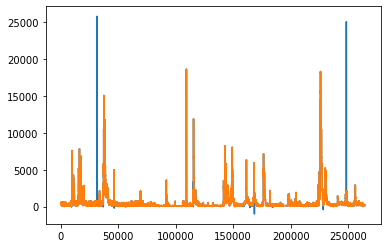

In [74]:
import matplotlib.pyplot as plt
plt.plot(df["tototf"].values)
plt.plot(impute_df["tototf"].values)